#Generating Result

In [ ]:
import pandas
import numpy
import csv


##import dataset
#already sotred according to country and then year 
#and continious year with no missing year gaps i.e. year must be present even if no value is available
df = pandas.read_csv('co2_emissions_kt_by_country.csv')
df['value'] = df['value'].astype(float)
countries = df['country_code'].unique()
data_rows = df.shape[0]



def LinearInterpolate(column):
  column_spline_interpolated = column.interpolate().ffill().bfill()
  return column_spline_interpolated

def CubicSplineInterpolate(column):
  ##missing value to interpolate is set as NaN
  #if enough datapoints apply spline else simple linear interpolation
  if(column.notnull().sum() > 3):
      column_spline_interpolated = column.interpolate('spline',order=3, s=0)
  else:
      column_spline_interpolated = column.interpolate().ffill().bfill()
  return column_spline_interpolated


def predictMissingValues(df_original, df_masked, interpolationFunction):
  #group by each country and interpolate within each
  #by using spline interpolation and ffill and bfill
  spline_interpolated_mean_abs_error = 0
  spline_interpolated_mean_sqr_error = 0
  for country in countries:
    df_country_selected_masked = df_masked.loc[df_masked['country_code'] == country]
    df_country_selected_original = df_original.loc[df_original['country_code'] == country]
    ##interpolate missing values
    df_country_spline_interpolated = interpolationFunction(df_country_selected_masked['value'])
    #error calculations
    df_spline_interpolated_error_country = df_country_spline_interpolated - df_country_selected_original['value']
    df_spline_interpolated_error_country_abs = df_spline_interpolated_error_country.abs()
    df_spline_interpolated_error_country_sqr = df_spline_interpolated_error_country ** 2
    spline_interpolated_country_abs_error = df_spline_interpolated_error_country_abs.sum()
    spline_interpolated_country_sqr_error = df_spline_interpolated_error_country_sqr.sum()
    ##add the total errors for each country
    spline_interpolated_mean_abs_error += spline_interpolated_country_abs_error
    spline_interpolated_mean_sqr_error += spline_interpolated_country_sqr_error
  
  spline_interpolated_mean_abs_error /= data_rows
  spline_interpolated_mean_sqr_error /= data_rows
  spline_interpolated_root_mean_sqr_error = spline_interpolated_mean_sqr_error ** 0.5
  return (spline_interpolated_mean_abs_error, spline_interpolated_root_mean_sqr_error)


def testMissingValuePredictionMethods(df, missing_proportion):
  ##randomly clear some values of emissions to simulate missing values
  # Generate random missing values on column values
  mask = numpy.random.choice([True, False], size=df['value'].shape[0], p=[missing_proportion, 1.0 - missing_proportion])
  a = df['value'].mask(mask)
  #print("Missing proportion:", a.isnull().sum(), "/", a.shape[0], '=', a.isnull().mean()*100)

  df_masked = df.copy()
  df_masked['value'] = a

  #get worst case maximum absolute error
  df_filled_zeros = df_masked.copy().fillna(0)
  df_max_error = df_filled_zeros['value'] - df['value']
  df_max_error_abs = df_max_error.abs()
  df_max_error_sqr = df_max_error ** 2

  max_mean_abs_error = df_max_error_abs.mean()
  max_mean_square_error = df_max_error_sqr.mean()
  max_root_mean_square_error = max_mean_square_error ** 0.5
  ##return max root mean square/absolute error and predictors(linear/cubic spline) max root mean square/absolute error
  linear_prediction_error = predictMissingValues(df, df_masked, LinearInterpolate)
  spline_prediction_error = predictMissingValues(df, df_masked,CubicSplineInterpolate)
  return[a.isnull().mean(), max_mean_abs_error        , max_root_mean_square_error, 
         linear_prediction_error[0], linear_prediction_error[1],
         spline_prediction_error[0], spline_prediction_error[1]]
  

def saveTestResultForMissingValues(filename, df, iter, missing_proportions):
  with open(filename, 'w') as outfile:
    writer = csv.writer(outfile)
    #print("missing_proportion,max_mean_abs_error,max_root_mean_square_error,linear_mean_abs_error,linear_root_mean_square_error,spline_mean_abs_error,spline_root_mean_square_error")
    for missing_proportion in missing_proportions:
      for i in range(iter):
        errors = testMissingValuePredictionMethods(df, missing_proportion)
        line = [missing_proportion] + errors[1:]
        #print(line)
        writer.writerow(line)

def generateResultsForMissingValues(df):
  filename = 'missing_value_interpolation.csv'
  iters = 10
  missing_proportions = [0.1,0.2,0.3,0.4,0.5,0.6]
  saveTestResultForMissingValues(filename, df, iters, missing_proportions)


if __name__ == "__main__":
  generateResultsForMissingValues(df)
  print("Result saved")



#Displaying result

               max_MAE      max_RMSE    linear_MAE   linear_RMSE  \
missing                                                            
0.1       84511.075688  9.256358e+05   1314.989242  20764.140068   
0.2      163891.840672  1.277284e+06   2890.341861  34119.735458   
0.3      246267.224470  1.574055e+06   4721.306181  43598.765585   
0.4      322080.275246  1.809183e+06   6806.014495  55643.916235   
0.5      413259.910687  2.064738e+06  10152.617678  71219.629343   

           spline_MAE    spline_RMSE  
missing                               
0.1       1448.564048   25273.847244  
0.2       3362.249690   41555.660803  
0.3       6034.550526   70012.208879  
0.4      10203.487410  157642.093226  
0.5      16257.031681  253687.929676  


Text(0, 0.5, 'Error percentage compared to maximum error')

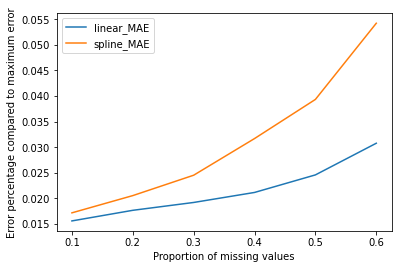

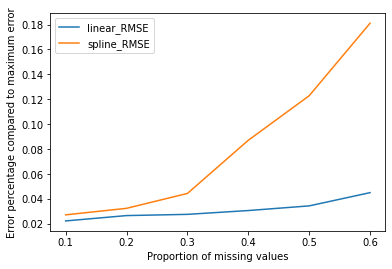

In [3]:
import pandas
import matplotlib.pyplot as plt

df_res = pandas.read_csv('missing_value_interpolation.csv')
df_res = df_res.groupby('missing')
df_res = df_res.mean()
print(df_res.head())
df_res = df_res.reset_index()

#normalizing by dividing by max possible error
df_res['linear_MAE'] = df_res['linear_MAE'] / df_res['max_MAE']
df_res['linear_RMSE'] = df_res['linear_RMSE'] / df_res['max_RMSE']

df_res['spline_MAE'] = df_res['spline_MAE'] / df_res['max_MAE']
df_res['spline_RMSE'] = df_res['spline_RMSE'] / df_res['max_RMSE']

##plot to compare cubic and linear interpolations
plt1 = df_res.plot(x='missing', y=['linear_MAE', 'spline_MAE', ])
plt1.set_xlabel("Proportion of missing values")
plt1.set_ylabel("Error percentage compared to maximum error")
plt2 = df_res.plot(x='missing', y=['linear_RMSE', 'spline_RMSE'])
plt2.set_xlabel("Proportion of missing values")
plt2.set_ylabel("Error percentage compared to maximum error")


=> Linear interpolation is better to predict missing values for kinds of data used here than a higher degree spline interpolation

=> Data itself might have been generated by linear interpolation for missing values?